# 📚 5.3修成正果篇-基于自编码器实现图像生成

自编码器（auto-encoder，AE）是经典的生成模型方法，它的框架图如图所示：

<img src="https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161829239860334671618292397960.png"/>

AE 可分为两个网络：

<h5>编码（encoder）网络，负责从 x 到 z，可称为 E；</h5>

<h5>解码（decoder）网络，负责从 z 到 x，可称为 G，因为它和 GAN 中的生成网络都是从 z 到 x。</h5>

可以从 x 到 z 看成是压缩信息的过程，从 z 到 x 看成是解压缩的过程。例如，如果 x 是 64*64 的彩色图像，那么它有 3*64*64=12288 维，reshape成一行，然后经过E的过程。得到z，而 z 往往只有 50 到 200 维。

# 一、本节目标

了解AE框架，编写AE代码，能在自己的数据集上训练自己的图片。

# 二、 实战

本节设置的模型如下图所示，最后重建的结果在左边download/AEimage中可查看。

<img src="https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161829251945288421618292517960.png"/>

## 2.1 数据集

我们使用了Fashion MNIST数据集，包含了 10 类不同类型的衣服、鞋子、包等灰度图片，图片大小为 28x28，共 70000 张图片，其中 60000 张用于训练集，10000 张用于测试集，每行为一种类别图片。可以看到，Fashion MNIST 除了图片内容与 MNIST 不一样，其 它设定都相同，大部分情况可以直接替换掉原来基于 MNIST 训练的算法代码，而不需要 额外修改。由于 Fashion MNIST 图片识别相对于 MNIST 图片更难，因此可以用于测试稍复杂的算法性能。

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from IPython.display import SVG
print(tf.__version__)

2.4.0


(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)
2.4.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.4
pandas 1.1.5
sklearn 0.24.1
tensorflow 2.4.0
tensorflow.keras 2.4.0


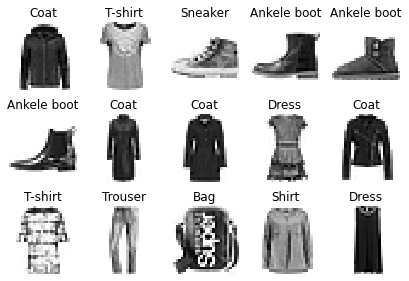

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline    
#为了能在notebook中显示图像
import numpy as np
import sklearn   
import pandas as pd 
import os 
import sys 
import time 
import tensorflow as tf 

from tensorflow import keras 
fashion_mnist = keras.datasets.fashion_mnist  #加载TensorFlow中自带的数据集

#拆分数据集，加载数据集后返回训练集以及测试集
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data() 

#将训练集进行一次拆分为验证集和训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:] 
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))   #设置图片大小
    #循环显示图片
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)     #subplot绘制子图
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            plt.axis('off')             #坐标轴不可见 
            plt.title(class_names[y_data[index]])
    plt.show()
    
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankele boot']
show_imgs(3, 5, x_train, y_train, class_names)


## 2.2 模型搭建

### 2.2.1 编码器的搭建

利用编码器 将输入图片x（24*24） flatten拉成784向量，经过编码器降维到20的向量里面。

### 2.2.2 解码器的搭建

由20个向量升维到原始图像大小，20-----128------256-----784

### 2.2.3整体框架

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
h_dim = 20 
class AE(Model):
    # 自编码器模型类，包含了Encoder 和Decoder2 个子网络
    def __init__(self):
        super(AE, self).__init__()
        # 创建Encoders 网络
        self.encoder = Sequential([
            layers.Dense(256, activation=tf.nn.relu),
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(h_dim)])
        # 创建Decoders 网络
        self.decoder = Sequential([
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(256, activation=tf.nn.relu),
            layers.Dense(784)])

    def call(self, inputs, training=None):
        #  前向传播函数
        #  编码获得隐藏向量h,[b, 784] => [b, 20]
        h = self.encoder(inputs)
        # 解码获得重建图片，[b, 20] => [b, 784]
        x_hat = self.decoder(h)
        return x_hat


## 2.3网络的训练

我们固定100个当作epoch

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt

batchsz = 128  # 批量大小
h_dim = 20  # 中间隐藏层维度
lr = 0.001

# 加载Fashion MNIST 图片数据集
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
# x_train shape: (60000, 28, 28) tf.Tensor(9, shape=(), dtype=uint8) tf.Tensor(0, shape=(), dtype=uint8)
print('x_test shape:', x_test.shape)  # x_test shape: (10000, 28, 28)

# 归一化
x_train, x_test = x_train.astype(np.float32) / 255., x_test.astype(np.float32) / 255.
# 只需要通过图片数据即可构建数据集对象，不需要标签
train_db = tf.data.Dataset.from_tensor_slices(x_train)
train_db = train_db.shuffle(10000).batch(batchsz)
# 构建测试集对象
test_db = tf.data.Dataset.from_tensor_slices(x_test)
test_db = test_db.shuffle(1000).batch(batchsz)


class AE(Model):
    # 自编码器模型类，包含了Encoder 和Decoder2 个子网络
    def __init__(self):
        super(AE, self).__init__()
        # 创建Encoders 网络
        self.encoder = Sequential([
            layers.Dense(256, activation=tf.nn.relu),
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(h_dim)])
        # 创建Decoders 网络
        self.decoder = Sequential([
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(256, activation=tf.nn.relu),
            layers.Dense(784)])

    def call(self, inputs, training=None):
        #  前向传播函数
        #  编码获得隐藏向量h,[b, 784] => [b, 20]
        h = self.encoder(inputs)
        # 解码获得重建图片，[b, 20] => [b, 784]
        x_hat = self.decoder(h)
        return x_hat


def save_images(imgs, name):
    # 创建280x280 大小图片阵列
    new_im = Image.new('L', (280, 280))
    index = 0
    for i in range(0, 280, 28):  # 10 行图片阵列
        for j in range(0, 280, 28):  # 10 列图片阵列
            im = imgs[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))  # 写入对应位置
            index += 1
    # 保存图片阵列
    new_im.save(name)


def draw():
    plt.figure()
    plt.plot(train_tot_loss, 'b', label='train')
    plt.plot(test_tot_loss, 'r', label='test')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.savefig('exam10.1_train_test_AE.png')
    plt.show()


# 创建网络对象
model = AE()
# 指定输入大小
model.build(input_shape=(None, 784))
# 打印网络信息
model.summary()
# 创建优化器，并设置学习率
optimizer = optimizers.Adam(lr=lr)
# 保存训练和测试过程中的误差情况
train_tot_loss = []
test_tot_loss = []


def main():
    for epoch in range(100):  # 训练100 个Epoch

        cor, tot = 0, 0
        for step, x in enumerate(train_db):  # 遍历训练集
            # 打平，[b, 28, 28] => [b, 784]
            x = tf.reshape(x, [-1, 784])
            # 构建梯度记录器
            with tf.GradientTape() as tape:
                # 前向计算获得重建的图片
                x_rec_logits = model(x)
                # 计算重建图片与输入之间的损失函数
                rec_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_rec_logits)
                # 计算均值
                rec_loss = tf.reduce_mean(rec_loss)
                cor += rec_loss
                tot += x.shape[0]
                # 自动求导，包含了2 个子网络的梯度
                grads = tape.gradient(rec_loss, model.trainable_variables)
                # 自动更新，同时更新2 个子网络
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
            if step % 100 == 0:
                # 间隔性打印训练误差
                print(epoch, step, float(rec_loss))
        train_tot_loss.append(cor / tot)

        correct, total = 0, 0
        for x in test_db:
            x = tf.reshape(x, [-1, 784])
            out = model(x)
            out_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=out)
            # 计算均值
            loss = tf.reduce_mean(out_loss)
            correct += loss
            total += x.shape[0]
        test_tot_loss.append(correct / total)

        if (epoch == 0) or (epoch == 9) or (epoch == 99):
            #  重建图像
            # 重建图片，从测试集采样一批图片
            x = next(iter(test_db))
            out_logits = model(tf.reshape(x, [-1, 784]))  # 打平并送入自编码器
            x_hat = tf.sigmoid(out_logits)  # 将输出转换为像素值，使用sigmoid 函数
            # 恢复为28x28,[b, 784] => [b, 28, 28]
            x_hat = tf.reshape(x_hat, [-1, 28, 28])
            # 输入的前50 张+重建的前50 张图片合并，[b, 28, 28] => [2b, 28, 28]
            x_concat = tf.concat([x[:50], x_hat[:50]], axis=0)
            x_concat = x_concat.numpy() * 255.  # 恢复为0~255 范围
            x_concat = x_concat.astype(np.uint8)  # 转换为整型
            save_images(x_concat, 'AEimage/rec_epoch_%d.png' % (epoch+1))  # 保存图片


if __name__ == '__main__':
    main()
    draw()

x_train shape: (60000, 28, 28) tf.Tensor(9, shape=(), dtype=uint8) tf.Tensor(0, shape=(), dtype=uint8)
x_test shape: (10000, 28, 28)
Model: "ae_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 20)                236436    
_________________________________________________________________
sequential_10 (Sequential)   (None, 784)               237200    
Total params: 473,636
Trainable params: 473,636
Non-trainable params: 0
_________________________________________________________________
0 0 0.6948649883270264
0 100 0.34502217173576355
0 200 0.3153379559516907
0 300 0.3157147467136383
0 400 0.29280951619148254
1 0 0.29101985692977905
1 100 0.29611092805862427
1 200 0.2944994270801544
1 300 0.3065933585166931
1 400 0.29173898696899414
2 0 0.2692664861679077
2 100 0.2937150001525879
2 200 0.2812938392162323
2 300 0.28207677602767944
2 400 0.2823846638202667
3 0 0.2705

## 2.4 图片重建

图片重建的效果如下，其中图片的左边 5 列为真实图片，右 边 5 列为对应的重建图片，可以看到，第一个 epoch 时，图片重建效果较差，图片非常模 糊，逼真度较差;随着训练的进行，重建图片边缘越来越清晰，第 100 个 epoch 时，重建 的图片效果已经比较接近真实图片。图片的重建代码在训练的模块中。

# 三、课后作业

1 自己设置一个深度的AE，完成自己数据集的 重建



2 掌握网络的输入输出维度变换